### N


In [3]:
# !pip install renishawWiRE
import numpy as np
import matplotlib.pyplot as plt
from renishawWiRE import WDFReader
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import glob
import os

# for deleting cosmic rays
from scipy.ndimage import median_filter


In [4]:
# # loading files to colab
# from google.colab import files

# uploaded = files.upload()

wdf_folder = './wdf'
if not os.path.exists(wdf_folder):
    os.makedirs(wdf_folder)
    print(f"Создана папка: {wdf_folder}")
    print("⚠️  ВНИМАНИЕ: Поместите ваши .wdf файлы в эту папку и запустите блок заново!")
else:
    print(f"✓ Папка {wdf_folder} найдена")
    
# Проверяем наличие файлов
wdf_files = glob.glob(os.path.join(wdf_folder, '*.wdf'))
if len(wdf_files) == 0:
    print(f"\n❌ В папке {wdf_folder} не найдено .wdf файлов!")
    print("Скопируйте ваши файлы в эту папку:")
    print(f"   - {os.path.abspath(wdf_folder)}")
else:
    print(f"\n✓ Найдено {len(wdf_files)} .wdf файлов:")
    for f in wdf_files:
        print(f"   - {os.path.basename(f)}")

✓ Папка ./wdf найдена

✓ Найдено 3 .wdf файлов:
   - cht_light-785-1200-nd10-5s_32x32_map.wdf
   - cht_dark-785-1200-nd10-5s_32x32_map.wdf
   - ad-785-nd10-5s-1200-HR-1.wdf


In [6]:
# Блок 2: Локальная загрузка файлов из папки 'wdf'
def read_wdf_file(filename):
    reader = WDFReader(filename)
    spectra = reader.spectra  # numpy array: shape (num_points, num_channels)
    xdata = reader.xdata  # wavenumbers (Raman shift)

    # Для картирования также получаем координаты
    try:
        xpos = reader.xpos  # X-координаты точек
        ypos = reader.ypos  # Y-координаты точек
        return spectra, xdata, xpos, ypos
    except:
        # Для single-point измерений координат может не быть
        return spectra, xdata, None, None

# Чтение всех .wdf файлов из папки 'wdf'
wdf_folder = './wdf'  # Путь к папке с файлами
filenames = sorted(glob.glob(os.path.join(wdf_folder, '*.wdf')))
print(f"Найдено файлов: {len(filenames)}\n")

data_list = []
file_labels = []  # Список имен файлов для легенд

for i, f in enumerate(filenames):
    basename = os.path.basename(f)
    print(f"[{i+1}] Загрузка файла: {basename}")
    data = read_wdf_file(f)
    data_list.append(data)
    file_labels.append(basename.replace('.wdf', ''))
    print(f"    Размер спектров: {data[0].shape}\n")

print(f"Всего загружено датасетов: {len(data_list)}")
print(f"Метки: {file_labels}")


Найдено файлов: 3

[1] Загрузка файла: ad-785-nd10-5s-1200-HR-1.wdf
    Размер спектров: (32, 32, 1011)

[2] Загрузка файла: cht_dark-785-1200-nd10-5s_32x32_map.wdf
    Размер спектров: (32, 32, 1011)

[3] Загрузка файла: cht_light-785-1200-nd10-5s_32x32_map.wdf
    Размер спектров: (32, 32, 1011)

Всего загружено датасетов: 3
Метки: ['ad-785-nd10-5s-1200-HR-1', 'cht_dark-785-1200-nd10-5s_32x32_map', 'cht_light-785-1200-nd10-5s_32x32_map']


In [7]:
# Блок 3: Удаление полиномиального фона из спектров
def remove_poly_background(spectra, degree=5):
    """
    Удаление полиномиального фона из спектров
    spectra: array формата (n_spectra, n_channels) или (x, y, n_channels)
    """
    original_shape = spectra.shape
    if len(original_shape) == 3:
        spectra_2d = spectra.reshape(-1, original_shape[-1])
    else:
        spectra_2d = spectra

    corrected = np.zeros_like(spectra_2d)
    x = np.arange(spectra_2d.shape[1])

    for i, spectrum in enumerate(spectra_2d):
        coeffs = np.polyfit(x, spectrum, degree)
        background = np.polyval(coeffs, x)
        corrected[i] = spectrum - background

    if len(original_shape) == 3:
        corrected = corrected.reshape(original_shape)

    return corrected

# Применяем к всем датасетам
spectra_cleaned_list = []
for i, data in enumerate(data_list):
    print(f"Удаление фона из датасета {i+1}: {file_labels[i]}...")
    cleaned = remove_poly_background(data[0])
    spectra_cleaned_list.append(cleaned)
    print(f"  Результат: {cleaned.shape}")


Удаление фона из датасета 1: ad-785-nd10-5s-1200-HR-1...
  Результат: (32, 32, 1011)
Удаление фона из датасета 2: cht_dark-785-1200-nd10-5s_32x32_map...
  Результат: (32, 32, 1011)
Удаление фона из датасета 3: cht_light-785-1200-nd10-5s_32x32_map...
  Результат: (32, 32, 1011)


In [8]:
# Блок 4: Удаление выбросов (cosmic ray removal)
def remove_cosmic_rays(spectra, threshold=3.0):
    """
    Удаление космических лучей на основе анализа производной
    """
    original_shape = spectra.shape
    if len(original_shape) == 3:
        spectra_2d = spectra.reshape(-1, original_shape[-1])
    else:
        spectra_2d = spectra.copy()

    cleaned = np.zeros_like(spectra_2d)

    for i, spectrum in enumerate(spectra_2d):
        deriv = np.gradient(spectrum)
        deriv_smooth = savgol_filter(deriv, window_length=5, polyorder=2)
        diff = np.abs(deriv - deriv_smooth)

        threshold_val = threshold * np.std(diff)
        spikes = diff > threshold_val

        spectrum_clean = spectrum.copy()
        if np.any(spikes):
            indices = np.arange(len(spectrum))
            spectrum_clean[spikes] = np.interp(indices[spikes],
                                                indices[~spikes],
                                                spectrum[~spikes])
        cleaned[i] = spectrum_clean

    if len(original_shape) == 3:
        cleaned = cleaned.reshape(original_shape)

    return cleaned

# Применяем удаление cosmic rays ко всем датасетам
spectra_cr_removed_list = []
for i, cleaned in enumerate(spectra_cleaned_list):
    print(f"Удаление cosmic rays из датасета {i+1}: {file_labels[i]}...")
    cr_removed = remove_cosmic_rays(cleaned)
    spectra_cr_removed_list.append(cr_removed)
    print(f"  Результат: {cr_removed.shape}")


Удаление cosmic rays из датасета 1: ad-785-nd10-5s-1200-HR-1...


  Результат: (32, 32, 1011)
Удаление cosmic rays из датасета 2: cht_dark-785-1200-nd10-5s_32x32_map...
  Результат: (32, 32, 1011)
Удаление cosmic rays из датасета 3: cht_light-785-1200-nd10-5s_32x32_map...
  Результат: (32, 32, 1011)


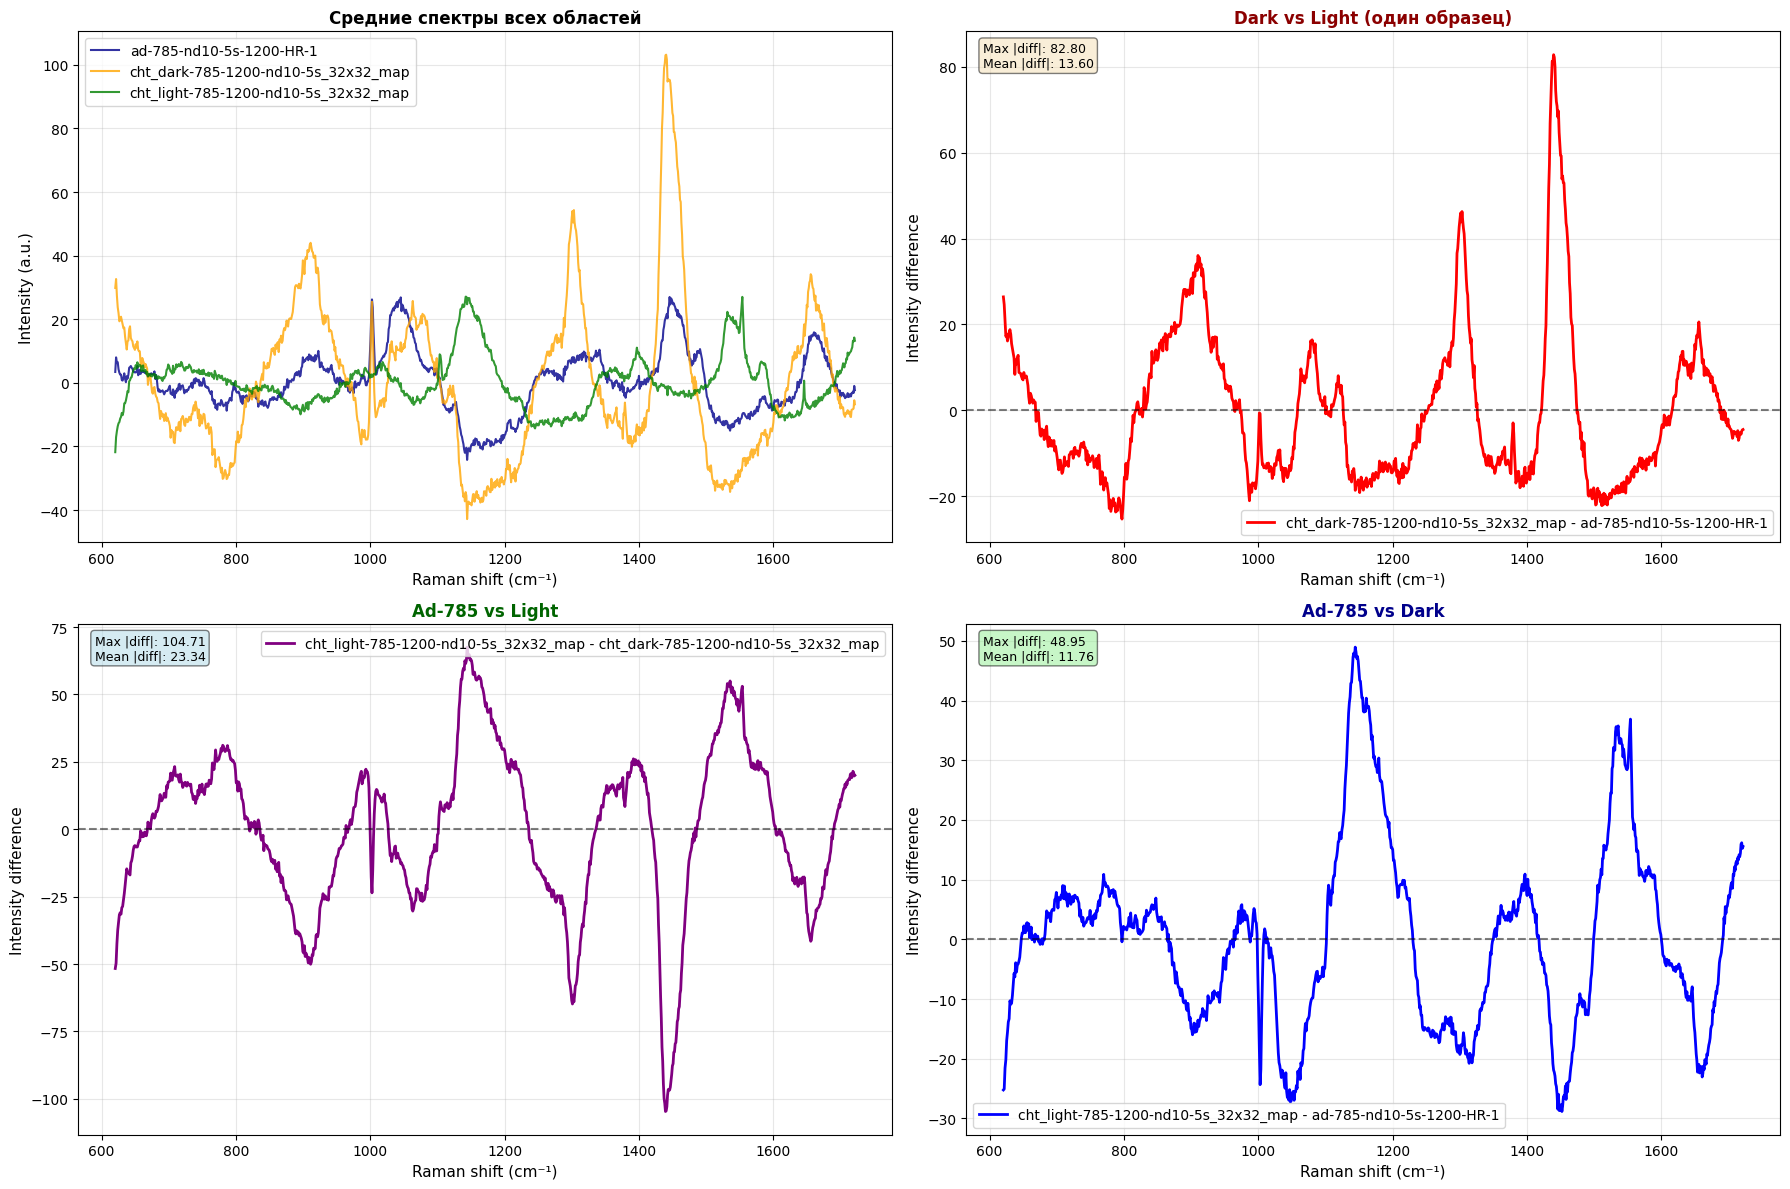


ПОЛНЫЙ СТАТИСТИЧЕСКИЙ АНАЛИЗ РАЗЛИЧИЙ МЕЖДУ СПЕКТРАМИ

🔴 ad-785-nd10-5s-1200-HR-1 vs cht_dark-785-1200-nd10-5s_32x32_map (ОДИН ОБРАЗЕЦ):
  • Максимальная разность: 82.8027
  • Средняя абс. разность: 13.6019
  • Стандартное отклонение: 17.8795
  • Относительная разность: 184.14%

🟣 cht_light-785-1200-nd10-5s_32x32_map vs cht_dark-785-1200-nd10-5s_32x32_map (РАЗНЫЕ ТКАНИ):
  • Максимальная разность: 104.7051
  • Средняя абс. разность: 23.3388
  • Стандартное отклонение: 29.7185
  • Относительная разность: 125.63%

🔵 cht_light-785-1200-nd10-5s_32x32_map vs ad-785-nd10-5s-1200-HR-1 (РАЗНЫЕ ТКАНИ):
  • Максимальная разность: 48.9519
  • Средняя абс. разность: 11.7571
  • Стандартное отклонение: 15.2823
  • Относительная разность: 159.17%

📊 ИТОГОВОЕ СРАВНЕНИЕ УРОВНЕЙ РАЗЛИЧИЙ

1️⃣  Dark vs Light (один образец):  13.6019
2️⃣  Ad-785 vs Light (разные ткани): 23.3388
3️⃣  Ad-785 vs Dark (разные ткани):  11.7571

🎯 ВЫВОДЫ:
  ✗ Ad-785 ДАЛЬШЕ от Light, чем Dark от Light (на 71.6%)
    → Различия

In [15]:
# Блок 5: Визуализация средних спектров для всех областей (4 ГРАФИКА)
def plot_average_spectra_all(spectra_list, labels_list, wavenumbers):
    """
    Построение графика средних спектров для всех областей
    """
    n_datasets = len(spectra_list)
    colors = ['darkblue', 'orange', 'green', 'red', 'purple']
    
    # Вычисляем средние спектры
    mean_spectra = []
    for i, data in enumerate(spectra_list):
        data_2d = data.reshape(-1, data.shape[-1])
        mean_spectrum = np.mean(data_2d, axis=0)
        mean_spectra.append(mean_spectrum)
    
    # Создаем фигуру с 4 графиками (2x2)
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    axes = axes.flatten()  # Преобразуем в 1D массив для удобства
    
    # График 1: Все средние спектры (абсолютные значения)
    for i, mean_spectrum in enumerate(mean_spectra):
        axes[0].plot(wavenumbers, mean_spectrum, 
                    label=labels_list[i], 
                    color=colors[i % len(colors)], 
                    linewidth=1.5, 
                    alpha=0.8)
    axes[0].set_xlabel('Raman shift (cm⁻¹)', fontsize=11)
    axes[0].set_ylabel('Intensity (a.u.)', fontsize=11)
    axes[0].set_title('Средние спектры всех областей', fontsize=12, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(alpha=0.3)
    
    # График 2: Dark vs Light (один образец)
    if len(mean_spectra) >= 2:
        difference_dark_light = mean_spectra[1] - mean_spectra[0]
        axes[1].plot(wavenumbers, difference_dark_light, 
                    color='red', linewidth=2, label=f'{labels_list[1]} - {labels_list[0]}')
        axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
        axes[1].set_xlabel('Raman shift (cm⁻¹)', fontsize=11)
        axes[1].set_ylabel('Intensity difference', fontsize=11)
        axes[1].set_title(f'Dark vs Light (один образец)', 
                         fontsize=12, fontweight='bold', color='darkred')
        axes[1].legend(fontsize=10)
        axes[1].grid(alpha=0.3)
        
        # Статистика
        max_diff = np.max(np.abs(difference_dark_light))
        mean_abs_diff = np.mean(np.abs(difference_dark_light))
        axes[1].text(0.02, 0.98, 
                    f'Max |diff|: {max_diff:.2f}\nMean |diff|: {mean_abs_diff:.2f}',
                    transform=axes[1].transAxes, 
                    verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                    fontsize=9)
    
    # График 3: Ad-785 vs Light
    if len(mean_spectra) >= 3:
        difference_ad_light = mean_spectra[2] - mean_spectra[1]
        axes[2].plot(wavenumbers, difference_ad_light, 
                    color='purple', linewidth=2, label=f'{labels_list[2]} - {labels_list[1]}')
        axes[2].axhline(y=0, color='black', linestyle='--', alpha=0.5)
        axes[2].set_xlabel('Raman shift (cm⁻¹)', fontsize=11)
        axes[2].set_ylabel('Intensity difference', fontsize=11)
        axes[2].set_title(f'Ad-785 vs Light', 
                         fontsize=12, fontweight='bold', color='darkgreen')
        axes[2].legend(fontsize=10)
        axes[2].grid(alpha=0.3)
        
        # Статистика
        max_diff_3 = np.max(np.abs(difference_ad_light))
        mean_abs_diff_3 = np.mean(np.abs(difference_ad_light))
        axes[2].text(0.02, 0.98, 
                    f'Max |diff|: {max_diff_3:.2f}\nMean |diff|: {mean_abs_diff_3:.2f}',
                    transform=axes[2].transAxes, 
                    verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5),
                    fontsize=9)
    
    # График 4: Ad-785 vs Dark (НОВЫЙ!)
    if len(mean_spectra) >= 3:
        difference_ad_dark = mean_spectra[2] - mean_spectra[0]
        axes[3].plot(wavenumbers, difference_ad_dark, 
                    color='blue', linewidth=2, label=f'{labels_list[2]} - {labels_list[0]}')
        axes[3].axhline(y=0, color='black', linestyle='--', alpha=0.5)
        axes[3].set_xlabel('Raman shift (cm⁻¹)', fontsize=11)
        axes[3].set_ylabel('Intensity difference', fontsize=11)
        axes[3].set_title(f'Ad-785 vs Dark', 
                         fontsize=12, fontweight='bold', color='darkblue')
        axes[3].legend(fontsize=10)
        axes[3].grid(alpha=0.3)
        
        # Статистика
        max_diff_4 = np.max(np.abs(difference_ad_dark))
        mean_abs_diff_4 = np.mean(np.abs(difference_ad_dark))
        axes[3].text(0.02, 0.98, 
                    f'Max |diff|: {max_diff_4:.2f}\nMean |diff|: {mean_abs_diff_4:.2f}',
                    transform=axes[3].transAxes, 
                    verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5),
                    fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # ===== ПОЛНАЯ СТАТИСТИКА ВСЕХ СРАВНЕНИЙ =====
    print("\n" + "="*70)
    print("ПОЛНЫЙ СТАТИСТИЧЕСКИЙ АНАЛИЗ РАЗЛИЧИЙ МЕЖДУ СПЕКТРАМИ")
    print("="*70)
    
    # 1. Dark vs Light
    if len(mean_spectra) >= 2:
        diff = mean_spectra[1] - mean_spectra[0]
        print(f"\n🔴 {labels_list[0]} vs {labels_list[1]} (ОДИН ОБРАЗЕЦ):")
        print(f"  • Максимальная разность: {np.max(np.abs(diff)):.4f}")
        print(f"  • Средняя абс. разность: {np.mean(np.abs(diff)):.4f}")
        print(f"  • Стандартное отклонение: {np.std(diff):.4f}")
        rel_diff = np.mean(np.abs(diff)) / np.mean(np.abs(mean_spectra[0]))
        print(f"  • Относительная разность: {rel_diff*100:.2f}%")
        dark_light_diff = np.mean(np.abs(diff))
    
    # 2. Ad-785 vs Light
    if len(mean_spectra) >= 3:
        diff = mean_spectra[2] - mean_spectra[1]
        print(f"\n🟣 {labels_list[2]} vs {labels_list[1]} (РАЗНЫЕ ТКАНИ):")
        print(f"  • Максимальная разность: {np.max(np.abs(diff)):.4f}")
        print(f"  • Средняя абс. разность: {np.mean(np.abs(diff)):.4f}")
        print(f"  • Стандартное отклонение: {np.std(diff):.4f}")
        rel_diff = np.mean(np.abs(diff)) / np.mean(np.abs(mean_spectra[1]))
        print(f"  • Относительная разность: {rel_diff*100:.2f}%")
        ad_light_diff = np.mean(np.abs(diff))
    
    # 3. Ad-785 vs Dark
    if len(mean_spectra) >= 3:
        diff = mean_spectra[2] - mean_spectra[0]
        print(f"\n🔵 {labels_list[2]} vs {labels_list[0]} (РАЗНЫЕ ТКАНИ):")
        print(f"  • Максимальная разность: {np.max(np.abs(diff)):.4f}")
        print(f"  • Средняя абс. разность: {np.mean(np.abs(diff)):.4f}")
        print(f"  • Стандартное отклонение: {np.std(diff):.4f}")
        rel_diff = np.mean(np.abs(diff)) / np.mean(np.abs(mean_spectra[0]))
        print(f"  • Относительная разность: {rel_diff*100:.2f}%")
        ad_dark_diff = np.mean(np.abs(diff))
    
    # ===== ИТОГОВОЕ СРАВНЕНИЕ =====
    if len(mean_spectra) >= 3:
        print("\n" + "="*70)
        print("📊 ИТОГОВОЕ СРАВНЕНИЕ УРОВНЕЙ РАЗЛИЧИЙ")
        print("="*70)
        print(f"\n1️⃣  Dark vs Light (один образец):  {dark_light_diff:.4f}")
        print(f"2️⃣  Ad-785 vs Light (разные ткани): {ad_light_diff:.4f}")
        print(f"3️⃣  Ad-785 vs Dark (разные ткани):  {ad_dark_diff:.4f}")
        
        # Выводы
        print("\n🎯 ВЫВОДЫ:")
        
        # Сравнение 1 и 2
        if ad_light_diff < dark_light_diff:
            ratio = (1 - ad_light_diff/dark_light_diff) * 100
            print(f"  ✓ Ad-785 БЛИЖЕ к Light, чем Dark к Light (на {ratio:.1f}%)")
            print(f"    → Light и Ad-785 имеют более похожий химический состав")
        else:
            ratio = (ad_light_diff/dark_light_diff - 1) * 100
            print(f"  ✗ Ad-785 ДАЛЬШЕ от Light, чем Dark от Light (на {ratio:.1f}%)")
            print(f"    → Различия между тканями сильнее, чем внутри одного образца")
        
        # Сравнение 2 и 3
        if ad_light_diff < ad_dark_diff:
            ratio = (1 - ad_light_diff/ad_dark_diff) * 100
            print(f"\n  ✓ Ad-785 БЛИЖЕ к Light, чем к Dark (на {ratio:.1f}%)")
            print(f"    → Третья ткань по составу ближе к светлому участку")
        else:
            ratio = (ad_light_diff/ad_dark_diff - 1) * 100
            print(f"\n  ✓ Ad-785 БЛИЖЕ к Dark, чем к Light (на {ratio:.1f}%)")
            print(f"    → Третья ткань по составу ближе к тёмному участку")
        
        # Дополнительная информация
        min_diff = min(ad_light_diff, ad_dark_diff)
        if min_diff == ad_light_diff:
            closest = "Light"
        else:
            closest = "Dark"
        print(f"\n  📌 ИТОГ: Ad-785 наиболее близок к {closest} участку первого образца")

# Используем wavenumbers из первого файла
wavenumbers = data_list[0][1]
plot_average_spectra_all(spectra_cr_removed_list, file_labels, wavenumbers)


In [ ]:
# # Блок 6: Нормализация данных для PCA и ML
# def normalize_spectra_map(spectra, method='standard'):
#     """
#     Нормализация спектров
#     """
#     original_shape = spectra.shape
#     spectra_2d = spectra.reshape(-1, original_shape[-1])

#     if method == 'standard':
#         scaler = StandardScaler()
#         spectra_norm = scaler.fit_transform(spectra_2d)
#     elif method == 'minmax':
#         from sklearn.preprocessing import MinMaxScaler
#         scaler = MinMaxScaler()
#         spectra_norm = scaler.fit_transform(spectra_2d)
#     elif method == 'vector':
#         from sklearn.preprocessing import normalize
#         spectra_norm = normalize(spectra_2d, norm='l2')
#     else:
#         spectra_norm = spectra_2d

#     return spectra_norm, original_shape

# # Нормализация всех датасетов
# norm_list = []
# for i, spectra in enumerate(spectra_cr_removed_list):
#     print(f"Нормализация датасета {i+1}: {file_labels[i]}...")
#     norm, shape = normalize_spectra_map(spectra, method='standard')
#     norm_list.append(norm)
#     print(f"  Результат: {norm.shape}")

# # Объединяем все датасеты для совместного анализа
# all_spectra_norm = np.vstack(norm_list)

# # Создаем метки для каждого класса (0, 1, 2, ...)
# labels = []
# for i, norm in enumerate(norm_list):
#     labels.extend([i] * norm.shape[0])
# labels = np.array(labels)

# print(f"\nОбщий датасет: {all_spectra_norm.shape}")
# print(f"Метки: {labels.shape}, уникальные классы: {np.unique(labels)}")
# print(f"Распределение по классам: {[(file_labels[i], np.sum(labels == i)) for i in range(len(norm_list))]}")


Нормализация датасета 1: ad-785-nd10-5s-1200-HR-1...
  Результат: (1024, 1011)
Нормализация датасета 2: cht_dark-785-1200-nd10-5s_32x32_map...
  Результат: (1024, 1011)
Нормализация датасета 3: cht_light-785-1200-nd10-5s_32x32_map...
  Результат: (1024, 1011)

Общий датасет: (3072, 1011)
Метки: (3072,), уникальные классы: [0 1 2]
Распределение по классам: [('ad-785-nd10-5s-1200-HR-1', np.int64(1024)), ('cht_dark-785-1200-nd10-5s_32x32_map', np.int64(1024)), ('cht_light-785-1200-nd10-5s_32x32_map', np.int64(1024))]


In [19]:
# Блок 6 (УЛУЧШЕННАЯ ВЕРСИЯ): Нормализация с выбором метода
def normalize_spectra_map(spectra, method='vector'):  # ИЗМЕНЕНО: 'vector' вместо 'standard'
    """
    Нормализация спектров
    method: 'standard' (StandardScaler) или 'minmax' или 'vector' (L2 norm) или 'area'
    """
    original_shape = spectra.shape
    spectra_2d = spectra.reshape(-1, original_shape[-1])

    if method == 'standard':
        scaler = StandardScaler()
        spectra_norm = scaler.fit_transform(spectra_2d)
    elif method == 'minmax':
        from sklearn.preprocessing import MinMaxScaler
        scaler = MinMaxScaler()
        spectra_norm = scaler.fit_transform(spectra_2d)
    elif method == 'vector':
        # L2 нормализация (каждый спектр к единичному вектору)
        from sklearn.preprocessing import normalize
        spectra_norm = normalize(spectra_2d, norm='l2')
    elif method == 'area':
        # Нормализация по площади под кривой (сумма = 1)
        spectra_norm = spectra_2d / np.sum(np.abs(spectra_2d), axis=1, keepdims=True)
    else:
        spectra_norm = spectra_2d

    return spectra_norm, original_shape

# Попробуйте 'vector' или 'area' вместо 'standard'
print("🔄 Тестирование разных методов нормализации...\n")

methods = ['standard', 'vector', 'area']
results = {}

for method in methods:
    print(f"--- Метод: {method.upper()} ---")
    
    # Нормализация
    norm_list_test = []
    for i, spectra in enumerate(spectra_cr_removed_list):
        norm, shape = normalize_spectra_map(spectra, method=method)
        norm_list_test.append(norm)
    
    # Объединяем
    all_spectra_test = np.vstack(norm_list_test)
    
    # PCA
    pca_test = PCA(n_components=10)
    pca_test.fit(all_spectra_test)
    
    # Результат
    explained_var = pca_test.explained_variance_ratio_
    cumsum_var = np.cumsum(explained_var)
    
    print(f"  PC1: {explained_var[0]*100:.2f}%")
    print(f"  PC1+PC2: {cumsum_var[1]*100:.2f}%")
    print(f"  PC1+PC2+PC3: {cumsum_var[2]*100:.2f}%")
    print(f"  Первые 10 компонент: {cumsum_var[9]*100:.2f}%\n")
    
    results[method] = cumsum_var[2]

# Выбираем лучший метод
best_method = max(results, key=results.get)
print(f"✅ ЛУЧШИЙ МЕТОД: {best_method.upper()} (PC1+PC2+PC3 = {results[best_method]*100:.1f}%)")
print(f"\nИспользуем метод '{best_method}' для дальнейшего анализа...\n")

# Применяем лучший метод
norm_list = []
for i, spectra in enumerate(spectra_cr_removed_list):
    print(f"Нормализация датасета {i+1}: {file_labels[i]} (метод: {best_method})...")
    norm, shape = normalize_spectra_map(spectra, method=best_method)
    norm_list.append(norm)
    print(f"  Результат: {norm.shape}")

# Далее как обычно...
all_spectra_norm = np.vstack(norm_list)
labels = []
for i, norm in enumerate(norm_list):
    labels.extend([i] * norm.shape[0])
labels = np.array(labels)

print(f"\nОбщий датасет: {all_spectra_norm.shape}")


🔄 Тестирование разных методов нормализации...

--- Метод: STANDARD ---
  PC1: 7.82%
  PC1+PC2: 10.01%
  PC1+PC2+PC3: 11.19%
  Первые 10 компонент: 15.59%

--- Метод: VECTOR ---
  PC1: 20.56%
  PC1+PC2: 23.19%
  PC1+PC2+PC3: 24.36%
  Первые 10 компонент: 27.04%

--- Метод: AREA ---
  PC1: 19.87%
  PC1+PC2: 22.41%
  PC1+PC2+PC3: 24.01%
  Первые 10 компонент: 30.01%

✅ ЛУЧШИЙ МЕТОД: VECTOR (PC1+PC2+PC3 = 24.4%)

Используем метод 'vector' для дальнейшего анализа...

Нормализация датасета 1: ad-785-nd10-5s-1200-HR-1 (метод: vector)...
  Результат: (1024, 1011)
Нормализация датасета 2: cht_dark-785-1200-nd10-5s_32x32_map (метод: vector)...
  Результат: (1024, 1011)
Нормализация датасета 3: cht_light-785-1200-nd10-5s_32x32_map (метод: vector)...
  Результат: (1024, 1011)

Общий датасет: (3072, 1011)


In [21]:
# Блок 5.5: Фильтрация спектрального диапазона
def filter_wavenumbers(spectra_list, wavenumbers, wn_min=400, wn_max=1800):
    """
    Оставляем только информативный диапазон wavenumbers
    """
    # Находим индексы нужного диапазона
    mask = (wavenumbers >= wn_min) & (wavenumbers <= wn_max)
    filtered_wavenumbers = wavenumbers[mask]
    
    filtered_spectra_list = []
    for spectra in spectra_list:
        if len(spectra.shape) == 3:
            filtered = spectra[:, :, mask]
        else:
            filtered = spectra[:, mask]
        filtered_spectra_list.append(filtered)
    
    print(f"\n🔬 Фильтрация wavenumbers:")
    print(f"  Было: {len(wavenumbers)} точек ({wavenumbers[0]:.1f} - {wavenumbers[-1]:.1f} cm⁻¹)")
    print(f"  Стало: {len(filtered_wavenumbers)} точек ({filtered_wavenumbers[0]:.1f} - {filtered_wavenumbers[-1]:.1f} cm⁻¹)")
    print(f"  Удалено: {len(wavenumbers) - len(filtered_wavenumbers)} точек ({(1-len(filtered_wavenumbers)/len(wavenumbers))*100:.1f}%)\n")
    
    return filtered_spectra_list, filtered_wavenumbers

# Применяем фильтрацию
print("="*70)
print("ШАГ: ФИЛЬТРАЦИЯ ИНФОРМАТИВНОГО ДИАПАЗОНА")
print("="*70)

spectra_filtered_list, wavenumbers_filtered = filter_wavenumbers(
    spectra_cr_removed_list, 
    wavenumbers, 
    wn_min=400,   # Типичный нижний предел для биологических тканей
    wn_max=1800   # Типичный верхний предел
)

# Обновляем wavenumbers для дальнейших графиков
wavenumbers = wavenumbers_filtered
spectra_cr_removed_list = spectra_filtered_list


ШАГ: ФИЛЬТРАЦИЯ ИНФОРМАТИВНОГО ДИАПАЗОНА

🔬 Фильтрация wavenumbers:
  Было: 1011 точек (1721.3 - 620.4 cm⁻¹)
  Стало: 1011 точек (1721.3 - 620.4 cm⁻¹)
  Удалено: 0 точек (0.0%)



In [23]:
# Блок 5.6: Дополнительное сглаживание спектров
from scipy.signal import savgol_filter

def smooth_spectra(spectra, window=11, polyorder=3):
    """
    Сглаживание спектров фильтром Савицкого-Голея
    """
    original_shape = spectra.shape
    if len(original_shape) == 3:
        spectra_2d = spectra.reshape(-1, original_shape[-1])
    else:
        spectra_2d = spectra.copy()
    
    smoothed = np.zeros_like(spectra_2d)
    for i, spectrum in enumerate(spectra_2d):
        smoothed[i] = savgol_filter(spectrum, window_length=window, polyorder=polyorder)
    
    if len(original_shape) == 3:
        smoothed = smoothed.reshape(original_shape)
    
    return smoothed

print("="*70)
print("ШАГ: СГЛАЖИВАНИЕ СПЕКТРОВ")
print("="*70)

spectra_smoothed_list = []
for i, spectra in enumerate(spectra_filtered_list):
    print(f"Сглаживание датасета {i+1}: {file_labels[i]}...")
    smoothed = smooth_spectra(spectra, window=11, polyorder=3)
    spectra_smoothed_list.append(smoothed)
    print(f"  Результат: {smoothed.shape}")

# Обновляем для следующих шагов
spectra_cr_removed_list = spectra_smoothed_list


ШАГ: СГЛАЖИВАНИЕ СПЕКТРОВ
Сглаживание датасета 1: ad-785-nd10-5s-1200-HR-1...
  Результат: (32, 32, 1011)
Сглаживание датасета 2: cht_dark-785-1200-nd10-5s_32x32_map...
  Результат: (32, 32, 1011)
Сглаживание датасета 3: cht_light-785-1200-nd10-5s_32x32_map...
  Результат: (32, 32, 1011)


In [24]:
# Блок 6 (ОБНОВЛЕННЫЙ): Сравнение методов нормализации
print("\n" + "="*70)
print("ШАГ: ТЕСТИРОВАНИЕ МЕТОДОВ НОРМАЛИЗАЦИИ")
print("="*70)

def normalize_spectra_map(spectra, method='vector'):
    original_shape = spectra.shape
    spectra_2d = spectra.reshape(-1, original_shape[-1])

    if method == 'standard':
        scaler = StandardScaler()
        spectra_norm = scaler.fit_transform(spectra_2d)
    elif method == 'minmax':
        from sklearn.preprocessing import MinMaxScaler
        scaler = MinMaxScaler()
        spectra_norm = scaler.fit_transform(spectra_2d)
    elif method == 'vector':
        from sklearn.preprocessing import normalize
        spectra_norm = normalize(spectra_2d, norm='l2')
    elif method == 'area':
        spectra_norm = spectra_2d / np.sum(np.abs(spectra_2d), axis=1, keepdims=True)
    elif method == 'snv':  # НОВЫЙ: Standard Normal Variate
        mean = np.mean(spectra_2d, axis=1, keepdims=True)
        std = np.std(spectra_2d, axis=1, keepdims=True)
        spectra_norm = (spectra_2d - mean) / (std + 1e-10)
    else:
        spectra_norm = spectra_2d

    return spectra_norm, original_shape

# Тестируем разные методы
methods = ['vector', 'area', 'snv', 'minmax', 'standard']
results = {}

for method in methods:
    print(f"\n--- Метод: {method.upper()} ---")
    
    norm_list_test = []
    for i, spectra in enumerate(spectra_cr_removed_list):
        norm, shape = normalize_spectra_map(spectra, method=method)
        norm_list_test.append(norm)
    
    all_spectra_test = np.vstack(norm_list_test)
    
    pca_test = PCA(n_components=10)
    pca_test.fit(all_spectra_test)
    
    explained_var = pca_test.explained_variance_ratio_
    cumsum_var = np.cumsum(explained_var)
    
    print(f"  PC1: {explained_var[0]*100:.2f}%")
    print(f"  PC1+PC2: {cumsum_var[1]*100:.2f}%")
    print(f"  PC1+PC2+PC3: {cumsum_var[2]*100:.2f}%")
    print(f"  Первые 5 компонент: {cumsum_var[4]*100:.2f}%")
    print(f"  Первые 10 компонент: {cumsum_var[9]*100:.2f}%")
    
    results[method] = cumsum_var[2]

# Выбираем лучший
best_method = max(results, key=results.get)
print("\n" + "="*70)
print(f"✅ ЛУЧШИЙ МЕТОД: {best_method.upper()}")
print(f"   PC1+PC2+PC3 = {results[best_method]*100:.1f}%")
print("="*70)

# Применяем лучший метод
norm_list = []
for i, spectra in enumerate(spectra_cr_removed_list):
    print(f"\nНормализация датасета {i+1}: {file_labels[i]} (метод: {best_method})...")
    norm, shape = normalize_spectra_map(spectra, method=best_method)
    norm_list.append(norm)
    print(f"  Результат: {norm.shape}")

all_spectra_norm = np.vstack(norm_list)
labels = []
for i, norm in enumerate(norm_list):
    labels.extend([i] * norm.shape[0])
labels = np.array(labels)

print(f"\n✅ Общий датасет: {all_spectra_norm.shape}")
print(f"   Метки: {labels.shape}, классы: {np.unique(labels)}")



ШАГ: ТЕСТИРОВАНИЕ МЕТОДОВ НОРМАЛИЗАЦИИ

--- Метод: VECTOR ---
  PC1: 38.27%
  PC1+PC2: 43.32%
  PC1+PC2+PC3: 45.43%
  Первые 5 компонент: 48.15%
  Первые 10 компонент: 50.73%

--- Метод: AREA ---
  PC1: 36.95%
  PC1+PC2: 41.82%
  PC1+PC2+PC3: 43.99%
  Первые 5 компонент: 47.33%
  Первые 10 компонент: 51.72%

--- Метод: SNV ---
  PC1: 38.31%
  PC1+PC2: 43.36%
  PC1+PC2+PC3: 45.47%
  Первые 5 компонент: 48.19%
  Первые 10 компонент: 50.78%

--- Метод: MINMAX ---
  PC1: 39.05%
  PC1+PC2: 57.18%
  PC1+PC2+PC3: 63.45%
  Первые 5 компонент: 66.94%
  Первые 10 компонент: 69.85%

--- Метод: STANDARD ---
  PC1: 16.49%
  PC1+PC2: 21.02%
  PC1+PC2+PC3: 23.68%
  Первые 5 компонент: 27.44%
  Первые 10 компонент: 32.86%

✅ ЛУЧШИЙ МЕТОД: MINMAX
   PC1+PC2+PC3 = 63.4%

Нормализация датасета 1: ad-785-nd10-5s-1200-HR-1 (метод: minmax)...
  Результат: (1024, 1011)

Нормализация датасета 2: cht_dark-785-1200-nd10-5s_32x32_map (метод: minmax)...
  Результат: (1024, 1011)

Нормализация датасета 3: cht_lig


PCA АНАЛИЗ С ОПТИМАЛЬНОЙ НОРМАЛИЗАЦИЕЙ (MinMax)


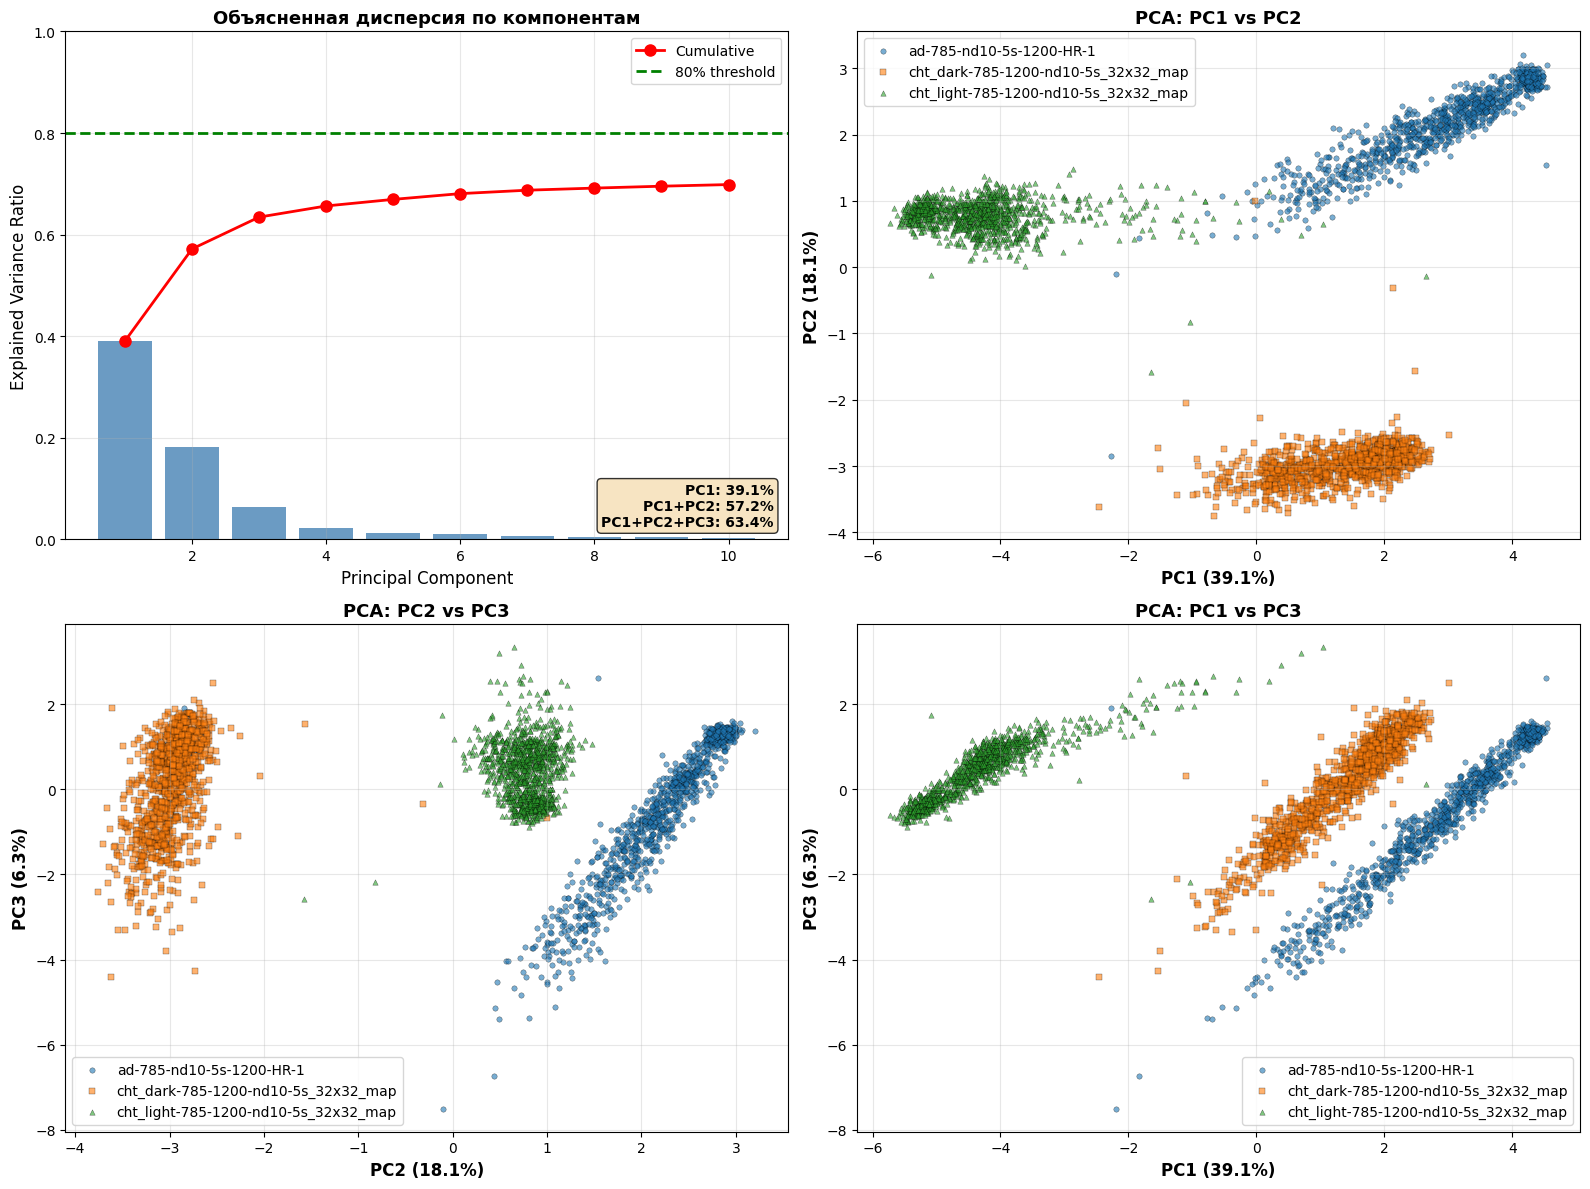


📊 РЕЗУЛЬТАТЫ PCA:
  • PC1 объясняет: 39.05%
  • PC1+PC2 объясняют: 57.18%
  • PC1+PC2+PC3 объясняют: 63.45%
  • Первые 5 компонент: 66.94%
  • Первые 10 компонент: 69.85%

✅ ИНТЕРПРЕТАЦИЯ:
  Отлично! 63.4% в 3 компонентах → сильные различия между датасетами


In [25]:
# Блок 7: PCA анализ и визуализация (с MinMax нормализацией)
print("\n" + "="*70)
print("PCA АНАЛИЗ С ОПТИМАЛЬНОЙ НОРМАЛИЗАЦИЕЙ (MinMax)")
print("="*70)

pca = PCA(n_components=10)
pca_result = pca.fit_transform(all_spectra_norm)

explained_var = pca.explained_variance_ratio_
cumsum_var = np.cumsum(explained_var)

# Создаем фигуру с 4 графиками
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# График 1: Объясненная дисперсия
axes[0].bar(range(1, 11), explained_var[:10], color='steelblue', alpha=0.8)
axes[0].plot(range(1, 11), cumsum_var[:10], 'ro-', linewidth=2, markersize=8, label='Cumulative')
axes[0].axhline(y=0.8, color='green', linestyle='--', linewidth=2, label='80% threshold')
axes[0].set_xlabel('Principal Component', fontsize=12)
axes[0].set_ylabel('Explained Variance Ratio', fontsize=12)
axes[0].set_title('Объясненная дисперсия по компонентам', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)
axes[0].set_ylim([0, 1])

# Добавляем текст с важными значениями
axes[0].text(0.98, 0.02, 
            f'PC1: {explained_var[0]*100:.1f}%\nPC1+PC2: {cumsum_var[1]*100:.1f}%\nPC1+PC2+PC3: {cumsum_var[2]*100:.1f}%',
            transform=axes[0].transAxes,
            verticalalignment='bottom',
            horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
            fontsize=10,
            fontweight='bold')

# График 2: PC1 vs PC2
colors_map = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Синий, Оранжевый, Зеленый
markers = ['o', 's', '^']

for i in range(len(norm_list)):
    mask = labels == i
    axes[1].scatter(pca_result[mask, 0], pca_result[mask, 1],
                   c=colors_map[i % len(colors_map)], 
                   marker=markers[i % len(markers)],
                   label=file_labels[i],
                   alpha=0.6, s=15, edgecolors='black', linewidth=0.3)

axes[1].set_xlabel(f'PC1 ({explained_var[0]*100:.1f}%)', fontsize=12, fontweight='bold')
axes[1].set_ylabel(f'PC2 ({explained_var[1]*100:.1f}%)', fontsize=12, fontweight='bold')
axes[1].set_title('PCA: PC1 vs PC2', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10, loc='best')
axes[1].grid(alpha=0.3)

# График 3: PC2 vs PC3
for i in range(len(norm_list)):
    mask = labels == i
    axes[2].scatter(pca_result[mask, 1], pca_result[mask, 2],
                   c=colors_map[i % len(colors_map)],
                   marker=markers[i % len(markers)],
                   label=file_labels[i],
                   alpha=0.6, s=15, edgecolors='black', linewidth=0.3)

axes[2].set_xlabel(f'PC2 ({explained_var[1]*100:.1f}%)', fontsize=12, fontweight='bold')
axes[2].set_ylabel(f'PC3 ({explained_var[2]*100:.1f}%)', fontsize=12, fontweight='bold')
axes[2].set_title('PCA: PC2 vs PC3', fontsize=13, fontweight='bold')
axes[2].legend(fontsize=10, loc='best')
axes[2].grid(alpha=0.3)

# График 4: PC1 vs PC3
for i in range(len(norm_list)):
    mask = labels == i
    axes[3].scatter(pca_result[mask, 0], pca_result[mask, 2],
                   c=colors_map[i % len(colors_map)],
                   marker=markers[i % len(markers)],
                   label=file_labels[i],
                   alpha=0.6, s=15, edgecolors='black', linewidth=0.3)

axes[3].set_xlabel(f'PC1 ({explained_var[0]*100:.1f}%)', fontsize=12, fontweight='bold')
axes[3].set_ylabel(f'PC3 ({explained_var[2]*100:.1f}%)', fontsize=12, fontweight='bold')
axes[3].set_title('PCA: PC1 vs PC3', fontsize=13, fontweight='bold')
axes[3].legend(fontsize=10, loc='best')
axes[3].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Выводим статистику
print(f"\n📊 РЕЗУЛЬТАТЫ PCA:")
print(f"  • PC1 объясняет: {explained_var[0]*100:.2f}%")
print(f"  • PC1+PC2 объясняют: {cumsum_var[1]*100:.2f}%")
print(f"  • PC1+PC2+PC3 объясняют: {cumsum_var[2]*100:.2f}%")
print(f"  • Первые 5 компонент: {cumsum_var[4]*100:.2f}%")
print(f"  • Первые 10 компонент: {cumsum_var[9]*100:.2f}%")

print(f"\n✅ ИНТЕРПРЕТАЦИЯ:")
if cumsum_var[2] > 0.6:
    print(f"  Отлично! {cumsum_var[2]*100:.1f}% в 3 компонентах → сильные различия между датасетами")
elif cumsum_var[2] > 0.4:
    print(f"  Хорошо! {cumsum_var[2]*100:.1f}% в 3 компонентах → заметные различия между датасетами")
else:
    print(f"  Умеренно. {cumsum_var[2]*100:.1f}% в 3 компонентах → различия есть, но не концентрированы")



t-SNE ВИЗУАЛИЗАЦИЯ
PCA предобработка: (3072, 1011) → (3072, 50)
Сохранено 78.6% дисперсии

Запуск t-SNE (может занять 1-3 минуты)...
✅ t-SNE завершен!



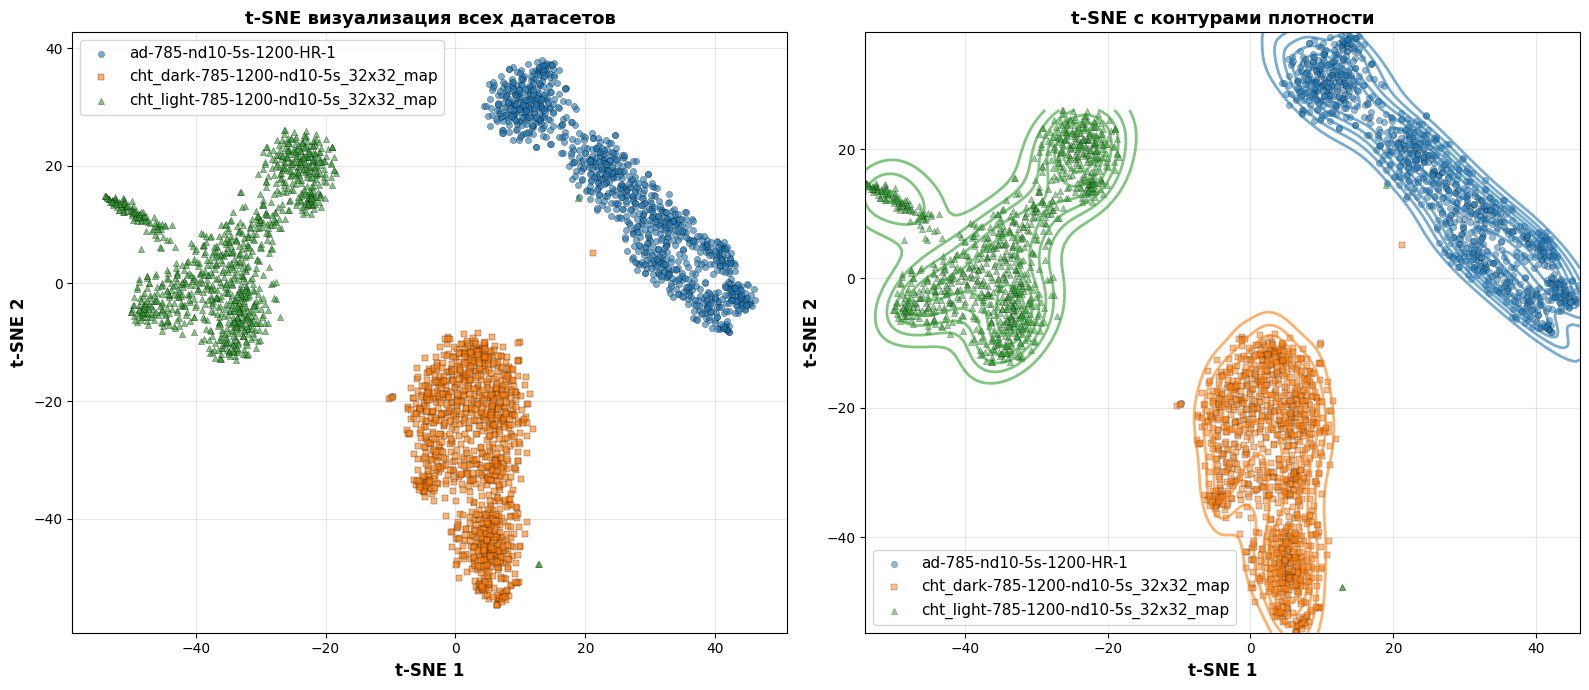

In [26]:
# Блок 8: t-SNE визуализация (с MinMax нормализацией)
print("\n" + "="*70)
print("t-SNE ВИЗУАЛИЗАЦИЯ")
print("="*70)

n_samples = all_spectra_norm.shape[0]

# Используем PCA предобработку для ускорения
pca_50 = PCA(n_components=50)
data_for_tsne = pca_50.fit_transform(all_spectra_norm)
print(f"PCA предобработка: {all_spectra_norm.shape} → {data_for_tsne.shape}")
print(f"Сохранено {np.sum(pca_50.explained_variance_ratio_)*100:.1f}% дисперсии\n")

print("Запуск t-SNE (может занять 1-3 минуты)...")
tsne = TSNE(n_components=2, 
            random_state=42, 
            perplexity=30, 
            max_iter=1000,
            learning_rate=200)
tsne_result = tsne.fit_transform(data_for_tsne)
print("✅ t-SNE завершен!\n")

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# График 1: t-SNE с цветовым кодированием
colors_map = ['#1f77b4', '#ff7f0e', '#2ca02c']
markers = ['o', 's', '^']

for i in range(len(norm_list)):
    mask = labels == i
    axes[0].scatter(tsne_result[mask, 0], tsne_result[mask, 1],
                   c=colors_map[i % len(colors_map)],
                   marker=markers[i % len(markers)],
                   label=file_labels[i],
                   alpha=0.6, s=20, edgecolors='black', linewidth=0.3)

axes[0].set_xlabel('t-SNE 1', fontsize=12, fontweight='bold')
axes[0].set_ylabel('t-SNE 2', fontsize=12, fontweight='bold')
axes[0].set_title('t-SNE визуализация всех датасетов', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11, loc='best')
axes[0].grid(alpha=0.3)

# График 2: t-SNE с плотностью (KDE)
from scipy.stats import gaussian_kde

for i in range(len(norm_list)):
    mask = labels == i
    xy = tsne_result[mask]
    
    # Рисуем точки
    axes[1].scatter(xy[:, 0], xy[:, 1],
                   c=colors_map[i % len(colors_map)],
                   marker=markers[i % len(markers)],
                   label=file_labels[i],
                   alpha=0.5, s=20, edgecolors='black', linewidth=0.3)
    
    # Добавляем контуры плотности
    try:
        kde = gaussian_kde(xy.T)
        x_min, x_max = xy[:, 0].min(), xy[:, 0].max()
        y_min, y_max = xy[:, 1].min(), xy[:, 1].max()
        xx, yy = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
        positions = np.vstack([xx.ravel(), yy.ravel()])
        f = np.reshape(kde(positions).T, xx.shape)
        axes[1].contour(xx, yy, f, colors=colors_map[i % len(colors_map)], 
                       alpha=0.6, linewidths=2)
    except:
        pass  # Если KDE не работает

axes[1].set_xlabel('t-SNE 1', fontsize=12, fontweight='bold')
axes[1].set_ylabel('t-SNE 2', fontsize=12, fontweight='bold')
axes[1].set_title('t-SNE с контурами плотности', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11, loc='best')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


| Аспект              | PCA                                                                    | t-SNE                                        |
| ------------------- | ---------------------------------------------------------------------- | -------------------------------------------- |
| Тип                 | Линейный метод                                                         | Нелинейный метод                             |
| Что сохраняет       | Глобальную структуру(главные направления вариации)                     | Локальную структуру(кто с кем рядом)         |
| Оси координат       | Имеют физический смысл (PC1, PC2 — направления максимальной дисперсии) | Не имеют смысла(это просто 2D карта)         |
| Расстояния          | Глобальные расстояния сохраняются                                      | Локальные расстояния важнее                  |
| Детерминированность | Всегда дает одинаковый результат                                       | Случайный старт→ каждый раз разный результат |
| Кластеры            | Могут быть размазаны                                                   | Формируетчёткие кластеры                     |



КЛАССИФИКАЦИЯ ДАТАСЕТОВ

📊 Размеры выборок:
  Train set: (2150, 1011)
  Test set: (922, 1011)
  Распределение train: [np.int64(717), np.int64(717), np.int64(716)]
  Распределение test:  [np.int64(307), np.int64(307), np.int64(308)]

1️⃣  LOGISTIC REGRESSION
                                      precision    recall  f1-score   support

            ad-785-nd10-5s-1200-HR-1       1.00      1.00      1.00       307
 cht_dark-785-1200-nd10-5s_32x32_map       1.00      1.00      1.00       307
cht_light-785-1200-nd10-5s_32x32_map       1.00      1.00      1.00       308

                            accuracy                           1.00       922
                           macro avg       1.00      1.00      1.00       922
                        weighted avg       1.00      1.00      1.00       922

Cross-validation accuracy: 0.998 (+/- 0.002)
Test accuracy: 0.999

2️⃣  RANDOM FOREST
                                      precision    recall  f1-score   support

            ad-785-nd10-5s-

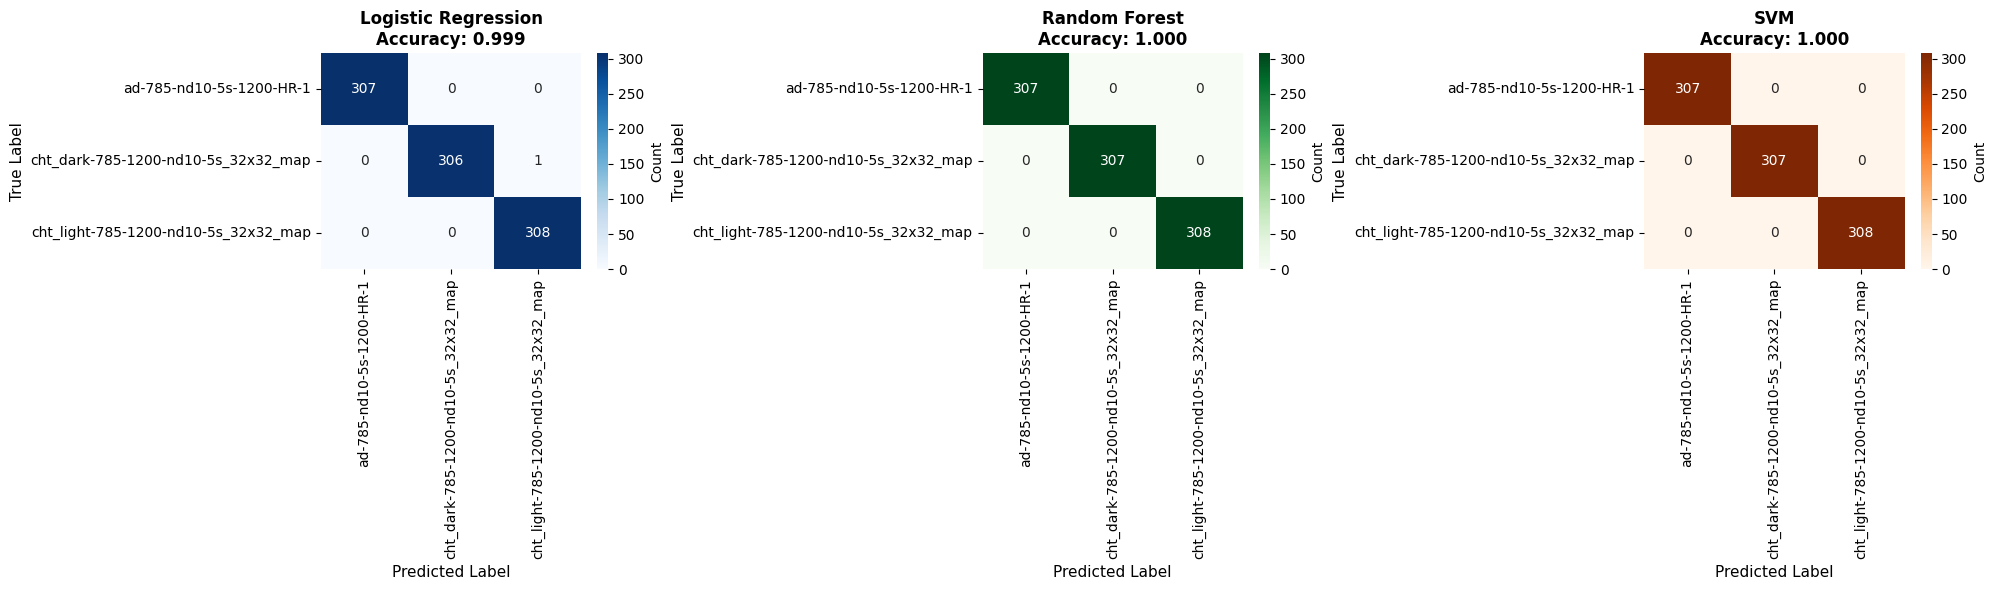

🎯 ИНТЕРПРЕТАЦИЯ РЕЗУЛЬТАТОВ

✅ ОТЛИЧНЫЙ РЕЗУЛЬТАТ (>90%):
  • Датасеты ЧЕТКО различимы по спектрам
  • Химический состав значительно различается
  • Raman-спектроскопия может надежно идентифицировать типы тканей



In [30]:
# Блок 9: Классификация с полной оценкой качества
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

print("\n" + "="*70)
print("КЛАССИФИКАЦИЯ ДАТАСЕТОВ")
print("="*70)

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    all_spectra_norm, labels, test_size=0.3, random_state=42, stratify=labels
)

print(f"\n📊 Размеры выборок:")
print(f"  Train set: {X_train.shape}")
print(f"  Test set: {X_test.shape}")
print(f"  Распределение train: {[np.sum(y_train == i) for i in range(len(file_labels))]}")
print(f"  Распределение test:  {[np.sum(y_test == i) for i in range(len(file_labels))]}\n")

# Словарь для хранения результатов
results = {}

# ========== Модель 1: Logistic Regression ==========
print("="*70)
print("1️⃣  LOGISTIC REGRESSION")
print("="*70)

lr = LogisticRegression(max_iter=2000, random_state=42, C=1.0)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print(classification_report(y_test, y_pred_lr, target_names=file_labels))

# Cross-validation
cv_scores_lr = cross_val_score(lr, all_spectra_norm, labels, cv=5)
print(f"Cross-validation accuracy: {cv_scores_lr.mean():.3f} (+/- {cv_scores_lr.std():.3f})")
print(f"Test accuracy: {accuracy_score(y_test, y_pred_lr):.3f}\n")

results['Logistic Regression'] = {
    'cv_mean': cv_scores_lr.mean(),
    'cv_std': cv_scores_lr.std(),
    'test_acc': accuracy_score(y_test, y_pred_lr),
    'predictions': y_pred_lr
}

# ========== Модель 2: Random Forest ==========
print("="*70)
print("2️⃣  RANDOM FOREST")
print("="*70)

rf = RandomForestClassifier(n_estimators=200, random_state=42, max_depth=15, min_samples_split=5)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print(classification_report(y_test, y_pred_rf, target_names=file_labels))

cv_scores_rf = cross_val_score(rf, all_spectra_norm, labels, cv=5)
print(f"Cross-validation accuracy: {cv_scores_rf.mean():.3f} (+/- {cv_scores_rf.std():.3f})")
print(f"Test accuracy: {accuracy_score(y_test, y_pred_rf):.3f}\n")

results['Random Forest'] = {
    'cv_mean': cv_scores_rf.mean(),
    'cv_std': cv_scores_rf.std(),
    'test_acc': accuracy_score(y_test, y_pred_rf),
    'predictions': y_pred_rf
}

# Feature importance для Random Forest
print("📊 Топ-10 наиболее важных wavenumbers (Random Forest):")
feature_importance = rf.feature_importances_
top_indices = np.argsort(feature_importance)[-10:][::-1]
for idx in top_indices:
    print(f"  Wavenumber {wavenumbers[idx]:.1f} cm⁻¹: importance = {feature_importance[idx]:.4f}")
print()

# ========== Модель 3: SVM (Support Vector Machine) ==========
print("="*70)
print("3️⃣  SUPPORT VECTOR MACHINE (SVM)")
print("="*70)

svm = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

print(classification_report(y_test, y_pred_svm, target_names=file_labels))

cv_scores_svm = cross_val_score(svm, all_spectra_norm, labels, cv=5)
print(f"Cross-validation accuracy: {cv_scores_svm.mean():.3f} (+/- {cv_scores_svm.std():.3f})")
print(f"Test accuracy: {accuracy_score(y_test, y_pred_svm):.3f}\n")

results['SVM'] = {
    'cv_mean': cv_scores_svm.mean(),
    'cv_std': cv_scores_svm.std(),
    'test_acc': accuracy_score(y_test, y_pred_svm),
    'predictions': y_pred_svm
}

# ========== Сравнение моделей ==========
print("="*70)
print("📊 СРАВНЕНИЕ МОДЕЛЕЙ")
print("="*70)
print(f"\n{'Модель':<25} {'CV Accuracy':<15} {'Test Accuracy':<15}")
print("-"*70)
for model_name, res in results.items():
    print(f"{model_name:<25} {res['cv_mean']:.3f} ± {res['cv_std']:.3f}    {res['test_acc']:.3f}")

best_model = max(results, key=lambda x: results[x]['cv_mean'])
print(f"\n✅ ЛУЧШАЯ МОДЕЛЬ: {best_model} (CV accuracy: {results[best_model]['cv_mean']:.3f})\n")

# ========== Confusion Matrices ==========
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues',
            xticklabels=file_labels, yticklabels=file_labels, ax=axes[0],
            cbar_kws={'label': 'Count'})
axes[0].set_title(f'Logistic Regression\nAccuracy: {results["Logistic Regression"]["test_acc"]:.3f}',
                 fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=11)
axes[0].set_xlabel('Predicted Label', fontsize=11)

# Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=file_labels, yticklabels=file_labels, ax=axes[1],
            cbar_kws={'label': 'Count'})
axes[1].set_title(f'Random Forest\nAccuracy: {results["Random Forest"]["test_acc"]:.3f}',
                 fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=11)
axes[1].set_xlabel('Predicted Label', fontsize=11)

# SVM
cm_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=file_labels, yticklabels=file_labels, ax=axes[2],
            cbar_kws={'label': 'Count'})
axes[2].set_title(f'SVM\nAccuracy: {results["SVM"]["test_acc"]:.3f}',
                 fontsize=12, fontweight='bold')
axes[2].set_ylabel('True Label', fontsize=11)
axes[2].set_xlabel('Predicted Label', fontsize=11)

plt.tight_layout()
plt.show()

# ========== Интерпретация ==========
print("="*70)
print("🎯 ИНТЕРПРЕТАЦИЯ РЕЗУЛЬТАТОВ")
print("="*70)

avg_accuracy = np.mean([res['cv_mean'] for res in results.values()])

if avg_accuracy > 0.9:
    print("\n✅ ОТЛИЧНЫЙ РЕЗУЛЬТАТ (>90%):")
    print("  • Датасеты ЧЕТКО различимы по спектрам")
    print("  • Химический состав значительно различается")
    print("  • Raman-спектроскопия может надежно идентифицировать типы тканей")
elif avg_accuracy > 0.7:
    print("\n✅ ХОРОШИЙ РЕЗУЛЬТАТ (70-90%):")
    print("  • Датасеты различимы, но есть перекрытия")
    print("  • Различия в химическом составе заметны")
    print("  • Возможна автоматическая классификация с небольшими ошибками")
elif avg_accuracy > 0.5:
    print("\n⚠️  УМЕРЕННЫЙ РЕЗУЛЬТАТ (50-70%):")
    print("  • Различия есть, но не очень сильные")
    print("  • Датасеты частично перекрываются")
    print("  • Требуется дополнительный анализ характерных пиков")
else:
    print("\n❌ СЛАБЫЙ РЕЗУЛЬТАТ (<50%):")
    print("  • Датасеты плохо различимы по спектрам")
    print("  • Химический состав очень похож")
    print("  • Возможно, различия визуальные, а не молекулярные")

print("\n" + "="*70)
